# This script estimate the system sensitivity as a function of the off-axis angle for a given camera geometry and mask code
The function `snr_vs_off_axis` in `mask_utils.imaging_utils` makes use of $eq. 13$ and $eq. 23$ from [G. K. Skinner - _"The sensitivity of coded mask telescopes"_, Applied Optics, 47, 15, 2739-2749 (2008)](https://opg.optica.org/ao/fulltext.cfm?uri=ao-47-15-2739&id=159530).

## Important! 
Here I'm **neglecting coarse spatial resolution**, which will lower the sensitivity (by reducing the coding power). As regards the fine resolution, in the following a default (probably optimistic) resolution of 50 $\mu$m is used.

In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.imaging_utils import snr_vs_off_axis, solid_angle
from mask_utils.fits_utils import read_mask_bulk

import matplotlib.pyplot as plt

## Reading mask and bulk FITS files

In [2]:
mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20250710.fits"
mask, hdmask = read_mask_bulk(mask_file, 'MASK', header_out=True, verbose=False)
bulk = read_mask_bulk(mask_file, 'SENS', verbose=False)

## Gettin mask and bulk properties

In [3]:
mask_x_pitch = hdmask['DXSLIT']
mask_y_pitch = hdmask['DYSLIT']
ELXDIM = hdmask['ELXDIM']
ELYDIM = hdmask['ELYDIM']
OPENFR = hdmask['OPENFR']
det_x_pitch = 0.080 #Standard spatial resolution
mask_thickness = 0.150
focal = 202.9

## Estimating Crab and CXB counts considering results from eXTP/WFM simulations

In [4]:
omega = solid_angle(bulk, ELXDIM, ELYDIM, focal, nobulk=True)

In [5]:
Crab = 1.85 #Crab rate on-axis pre-mask, rescaled from WFM sims
CXB = 5.2 # counts cm-2 sr-1 pre-mask

In [6]:
s_counts = Crab * (OPENFR/0.215799) #Rescaled using WFM oper-fraction
b_counts = CXB * np.max(omega) * OPENFR

print("Src/bkg counts cm2 s-1:", s_counts, b_counts)
print("CXB counts per pixel in 10ks:", b_counts * ((ELXDIM * ELYDIM)/100) * 10E3) # CXB counts per pixel in 10ks


Src/bkg counts cm2 s-1: 3.760608317434905 2.702043734014562
CXB counts per pixel in 10ks: 33.77554667518203


## Generating coordinate arrays

In [7]:
thetaX = np.linspace(-40, 40, 33)
thetaY = np.linspace(-40, 40, 33)

## Calculating 5$\sigma$ sensitivity in 1 s, expressed in mCrab

In [8]:

sensMap_x = [1000 / ( snr_vs_off_axis(s_counts, b_counts, mask, bulk, mask_x_pitch, mask_y_pitch, ELXDIM, ELYDIM, det_x_pitch, focal, mask_thickness, theta, 0, degrees=True)/5) for theta in thetaX]
sensMap_y = [1000 / ( snr_vs_off_axis(s_counts, b_counts, mask, bulk, mask_x_pitch, mask_y_pitch, ELXDIM, ELYDIM, det_x_pitch, focal, mask_thickness, 0, theta, degrees=True)/5) for theta in thetaY]

peak_snr = np.sqrt(1000) * snr_vs_off_axis(s_counts, b_counts, mask, bulk, mask_x_pitch, mask_y_pitch, ELXDIM, ELYDIM, det_x_pitch, focal, mask_thickness, 0, 0, degrees=True)

print ("1ks expected Crab significance (on-axis):", int(peak_snr))

1ks expected Crab significance (on-axis): 333


## We now repeat the same calculation for eXTP/WFM to compare perfomance

In [9]:
mask_file = "F:/LEM-X/IROS/wfm_mask.fits"
mask_wfm, hdmask_wfm = read_mask_bulk(mask_file, 'MASK', header_out=True, verbose=False)
bulk_wfm = read_mask_bulk(mask_file, 'SENS', verbose=False)

mask_x_pitch_wfm = hdmask_wfm['DXSLIT']
mask_y_pitch_wfm = hdmask_wfm['DYSLIT']
ELXDIM_wfm = hdmask_wfm['ELXDIM']
ELYDIM_wfm = hdmask_wfm['ELYDIM']
OPENFR_wfm = hdmask_wfm['OPENFR']
det_x_pitch = 0.050 #Standard spatial resolution
mask_thickness = 0.150
focal = 202.9

omega_wfm = solid_angle(bulk_wfm, ELXDIM_wfm, ELYDIM_wfm, focal, nobulk=True)

s_counts_wfm =  Crab * (OPENFR_wfm/0.215799) #Crab rate on-axis pre-mask, rescaled from WFM sims

b_counts_wfm = CXB * np.max(omega_wfm) * OPENFR_wfm
print("Src/bkg counts cm2 s-1 [WFM]:", s_counts_wfm, b_counts_wfm)
print("CXB counts per pixel in 10ks [WFM]:", b_counts_wfm * ((ELXDIM_wfm* ELYDIM_wfm)/100) * 10E3) # CXB counts per pixel in 10ks

Src/bkg counts cm2 s-1 [WFM]: 1.8499984274759733 1.3255298157852269
CXB counts per pixel in 10ks [WFM]: 13.25529815785227


In [10]:
sensMap_x_wfm = [1000 / ( snr_vs_off_axis(s_counts_wfm, b_counts_wfm, mask_wfm, bulk_wfm, mask_x_pitch_wfm, mask_y_pitch_wfm, ELXDIM_wfm, ELYDIM_wfm, det_x_pitch, focal, mask_thickness, theta, 0, degrees=True)/5) for theta in thetaX]
sensMap_y_wfm = [1000 / ( snr_vs_off_axis(s_counts_wfm, b_counts_wfm, mask_wfm, bulk_wfm, mask_x_pitch_wfm, mask_y_pitch_wfm, ELXDIM_wfm, ELYDIM_wfm, det_x_pitch, focal, mask_thickness, 0, theta, degrees=True)/5) for theta in thetaY]

peak_snr_wfm = np.sqrt(1000) * snr_vs_off_axis(s_counts_wfm, b_counts_wfm, mask_wfm, bulk_wfm, mask_x_pitch_wfm, mask_y_pitch_wfm, ELXDIM_wfm, ELYDIM_wfm, det_x_pitch, focal, mask_thickness, 0, 0, degrees=True)

print ("1ks expected Crab significance (on-axis) [WFM]:", int(peak_snr_wfm))

1ks expected Crab significance (on-axis) [WFM]: 233


## Plotting results

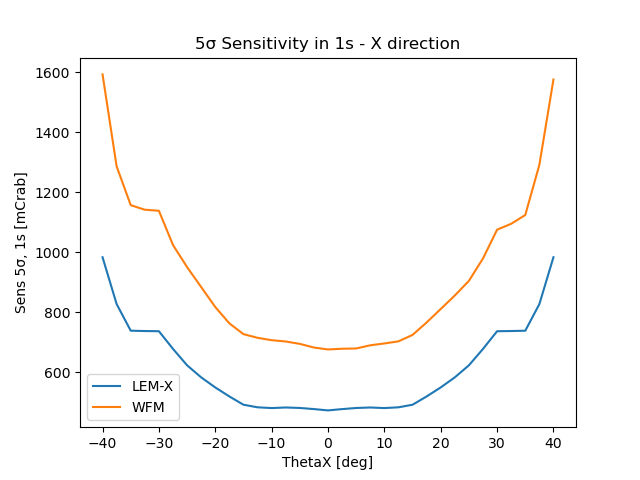

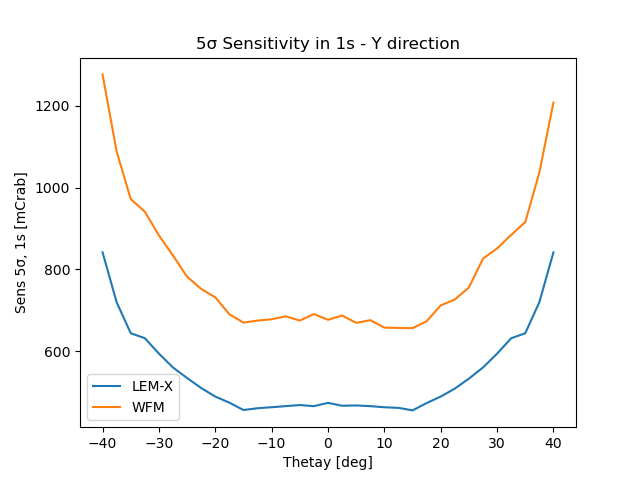

In [11]:
plt.figure()
plt.title("5σ Sensitivity in 1s - X direction")
plt.plot(thetaX, sensMap_x, label="LEM-X")
plt.plot(thetaX, sensMap_x_wfm, label="WFM")
plt.xlabel("ThetaX [deg]")
plt.ylabel("Sens 5σ, 1s [mCrab]")
plt.legend()
plt.show()

plt.figure()
plt.title("5σ Sensitivity in 1s - Y direction")
plt.plot(thetaY, sensMap_y, label="LEM-X")
plt.plot(thetaY, sensMap_y_wfm, label="WFM")
plt.xlabel("Thetay [deg]")
plt.ylabel("Sens 5σ, 1s [mCrab]")
plt.legend()
plt.show()

Mean gain in X: 1.4877704700073842
Mean gain in Y: 1.457393205182107


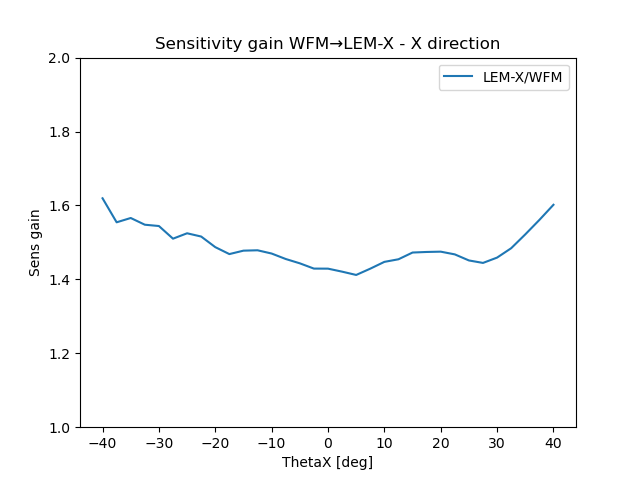

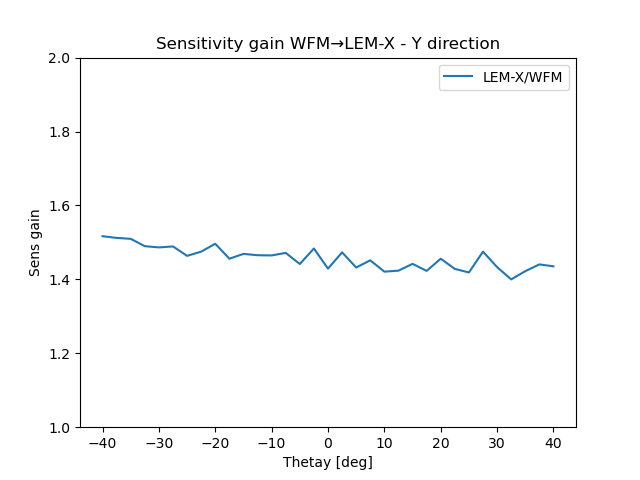

In [12]:
#Calculating gain factor
sx = np.shape(sensMap_x_wfm)
sy = np.shape(sensMap_y_wfm)

gain_x = [sensMap_x_wfm[i]/sensMap_x[i] for i in range(sx[0])]
gain_y = [sensMap_y_wfm[i]/sensMap_y[i] for i in range(sy[0])]

print("Mean gain in X:", np.mean(gain_x))
print("Mean gain in Y:", np.mean(gain_y))

plt.figure()
plt.title("Sensitivity gain WFM→LEM-X - X direction")
plt.plot(thetaX, gain_x, label="LEM-X/WFM")
plt.xlabel("ThetaX [deg]")
plt.ylabel("Sens gain")
plt.ylim((1,2))
plt.legend()
plt.show()

plt.figure()
plt.title("Sensitivity gain WFM→LEM-X - Y direction")
plt.plot(thetaY, gain_y, label="LEM-X/WFM")
plt.xlabel("Thetay [deg]")
plt.ylabel("Sens gain")
plt.ylim((1,2))
plt.legend()
plt.show()